# Physics Informed Neural Networks for the 1D Burgers' Equation 

## Introduction

Burgers' equation is a fundamental partial differential equation (PDE) encountered in various branches of physics, especially fluid mechanics. Its significance arises from the combination of advective and diffusive terms, leading to phenomena like shock waves.

Given by:
$$ \frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2} $$

Here, 
- $ u(x, t) $ is the velocity field dependent on spatial coordinate \( x \) and time $ t $.
- $ \nu $ represents the kinematic viscosity.

The equation balances non-linear advection with diffusion. Solutions to this equation can exhibit complex behaviors, especially when non-linearity dominates.

## Physics Informed Neural Networks (PINNs)

PINNs offer a novel approach to solving PDEs. Unlike traditional numerical methods, PINNs leverage the power of deep learning, incorporating the governing physical laws (PDEs) directly into the neural network's loss function.

### Key Advantages:

1. **Boundary Conditions**: PINNs can inherently satisfy complex boundary conditions.
2. **High-dimensional Problems**: They are well-suited for problems with many dimensions which might be intractable for classical solvers.
3. **Adaptive Resolution**: Neural networks can adapt to the complexities of the solution, offering higher resolution where needed.

### Approach:

- Train a neural network $ u_{NN}(x, t) $ to approximate the solution $ u(x, t) $.
- Compute derivatives of $ u_{NN}(x, t) $ with respect to its inputs.
- Enforce the Burgers' equation on the network's output by incorporating it into the loss function.

In [25]:
import math
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import torch
import torch.nn as nn

In [26]:
class NN(nn.Module):
    """
    Physics-Informed Neural Network (PINN) for the Burgers' equation.
    
    This network is constructed using multiple fully-connected layers 
    and tanh activation functions.
    """
    
    def __init__(self):
        """Initialize the BurgersPINN class."""
        super(NN, self).__init__()
        
        # Define the neural network architecture
        self.net = nn.Sequential(
            nn.Linear(2, 20),   # Input layer: 2 inputs (x, t)
            nn.Tanh(),          # Activation function
            
            nn.Linear(20, 30),  # Hidden layer
            nn.Tanh(),          # Activation function
            
            nn.Linear(30, 30),  # Hidden layer
            nn.Tanh(),          # Activation function
            
            nn.Linear(30, 20),  # Hidden layer
            nn.Tanh(),          # Activation function
            
            nn.Linear(20, 20),  # Hidden layer
            nn.Tanh(),          # Activation function
            
            nn.Linear(20, 1)    # Output layer: 1 output (u or velocity)
        )

    def forward(self, x):
        """Perform forward pass."""
        return self.net(x)

In [27]:
class Net:
    def __init__(self):
        # Set device for computation (CUDA for GPU or CPU)
        self.device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        
        # Define the neural network model
        self.model = NN().to(self.device)
        
        # Define Computational Domain
        self.h = 0.1  # Spatial step size
        self.k = 0.1  # Temporal step size
        x = torch.arange(-1, 1+self.h, self.h)
        t = torch.arange(0, 1+self.k, self.k)
        self.X = torch.stack(torch.meshgrid(x, t)).reshape(2, -1).T.to(self.device)
        self.X.requires_grad = True  # Required for automatic differentiation
        
        # Prepare Training Data with boundary and initial conditions
        self._prepare_training_data(x, t)
        
        # Define optimizers and loss function
        self._setup_optimization()
        
        # Initialize iteration counter for loss printing
        self.iter = 1

    def _prepare_training_data(self, x, t):
        # Boundary and initial conditions
        bc1 = torch.stack(torch.meshgrid(x[0], t)).reshape(2, -1).T
        bc2 = torch.stack(torch.meshgrid(x[-1], t)).reshape(2, -1).T
        ic = torch.stack(torch.meshgrid(x, t[0])).reshape(2, -1).T
        self.X_train = torch.cat([bc1, bc2, ic]).to(self.device)
        
        y_bc1 = torch.zeros(len(bc1))
        y_bc2 = torch.zeros(len(bc2))
        y_ic = -torch.sin(math.pi * ic[:, 0])
        self.y_train = torch.cat([y_bc1, y_bc2, y_ic]).unsqueeze(1).to(self.device)
    
    def _setup_optimization(self):
        # Adam optimizer
        self.adam = torch.optim.Adam(self.model.parameters())
        
        # Limited-memory Broyden-Fletcher-Goldfarb-Shanno (L-BFGS) optimizer
        self.optimizer = torch.optim.LBFGS(
            self.model.parameters(),
            lr=1.0,
            max_iter=50000,
            max_eval=50000,
            history_size=50,
            tolerance_grad=1e-7,
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"
        )
        
        # Mean squared error loss function
        self.criterion = torch.nn.MSELoss()

    def loss_func(self):
        """Compute the physics-informed loss function."""
        self.adam.zero_grad()
        self.optimizer.zero_grad()
        
        # Loss due to boundary and initial conditions
        y_pred = self.model(self.X_train)
        loss_data = self.criterion(y_pred, self.y_train)
        
        # Compute gradients required for the PDE loss term
        u = self.model(self.X)
        du_dX = torch.autograd.grad(u, self.X, grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True)[0]
        du_dt, du_dx = du_dX[:, 1], du_dX[:, 0]
        du_dXX = torch.autograd.grad(du_dX, self.X, grad_outputs=torch.ones_like(du_dX), create_graph=True, retain_graph=True)[0]
        du_dxx = du_dXX[:, 0]
        
        # Loss due to PDE
        loss_pde = self.criterion(du_dt + u.squeeze() * du_dx, (0.01 / math.pi) * du_dxx)
        
        # Total loss
        loss = loss_pde + loss_data
        loss.backward()
        
        # Print loss every 100 iterations
        if self.iter % 100 == 0:
            print(f"Iteration {self.iter}: Loss {loss.item()}")
        self.iter += 1
        
        return loss
    
    def train(self):
        """Train the model using the defined optimizers."""
        self.model.train()
        for _ in range(1000):
            self.adam.step(self.loss_func)
        self.optimizer.step(self.loss_func)
    
    def eval_(self):
        """Set the model to evaluation mode."""
        self.model.eval()

In [28]:
def evaluate_model(model, device, h=0.01, k=0.01):
    """
    Evaluates the model on a grid defined by meshing x and t.
    
    Parameters:
        model: Trained neural network model.
        device: Device where computations are performed (CPU or CUDA).
        h: Spatial step size.
        k: Temporal step size.

    Returns:
        y_pred: Predicted values on the grid.
    """
    # Define computational domain
    x = torch.arange(-1, 1, h)
    t = torch.arange(0, 1, k)

    X = torch.stack(torch.meshgrid(x, t)).reshape(2, -1).T
    X = X.to(device)
    
    model.eval()
    with torch.no_grad():
        y_pred = model(X)
        y_pred = y_pred.reshape(len(x), len(t)).cpu().numpy()
    
    return y_pred

In [29]:
def plot_heatmap(data, h=0.01, k=0.01):
    """
    Plots a heatmap of the given data with improved aesthetics.
    
    Parameters:
        data: 2D numpy array representing the heatmap data.
        h: Spatial step size (x-axis).
        k: Temporal step size (y-axis).
    """
    # Set the style of the visualization
    sns.set_style("white")
    
    # Create a figure and a set of subplots
    plt.figure(figsize=(8, 6), dpi=300)
    
    # Plotting the heatmap
    ax = sns.heatmap(data, cmap='jet', cbar_kws={'label': 'Intensity'})
    
    # Setting the labels and title
    ax.set_xlabel('Spatial Domain (x)', fontsize=14)
    ax.set_ylabel('Temporal Domain (t)', fontsize=14)
    ax.set_title('Heatmap of 1D Burgers\' Equation', fontsize=16)
    
    # Customizing the ticks for clarity
    xticks = list(range(0, data.shape[1], int(data.shape[1] / 10)))
    yticks = list(range(0, data.shape[0], int(data.shape[0] / 10)))
    
    ax.set_xticks(xticks)
    ax.set_xticklabels(['{:.2f}'.format(val * h) for val in xticks])
    
    ax.set_yticks(yticks)
    ax.set_yticklabels(['{:.2f}'.format(val * k) for val in yticks])
    
    # Ensure the plot is displayed correctly
    plt.tight_layout()
    plt.show()

Iteration 100: Loss 0.15501317381858826
Iteration 200: Loss 0.0897277295589447
Iteration 300: Loss 0.07592455297708511
Iteration 400: Loss 0.06345085799694061
Iteration 500: Loss 0.04602202773094177
Iteration 600: Loss 0.05046073719859123
Iteration 700: Loss 0.02430189773440361
Iteration 800: Loss 0.01881112903356552
Iteration 900: Loss 0.01839253306388855
Iteration 1000: Loss 0.01428530178964138
Iteration 1100: Loss 0.008137254044413567
Iteration 1200: Loss 0.004216841422021389
Iteration 1300: Loss 0.002099711215123534
Iteration 1400: Loss 0.0012992983683943748
Iteration 1500: Loss 0.000866416550707072
Iteration 1600: Loss 0.0005817062919959426
Iteration 1700: Loss 0.0004946148837916553
Iteration 1800: Loss 0.00042572873644530773
Iteration 1900: Loss 0.0002951386268250644
Iteration 2000: Loss 0.00024252459115814418
Iteration 2100: Loss 0.00020744858193211257
Iteration 2200: Loss 0.00016329740174114704
Iteration 2300: Loss 0.00014460811507888138
Iteration 2400: Loss 0.00012071322998963

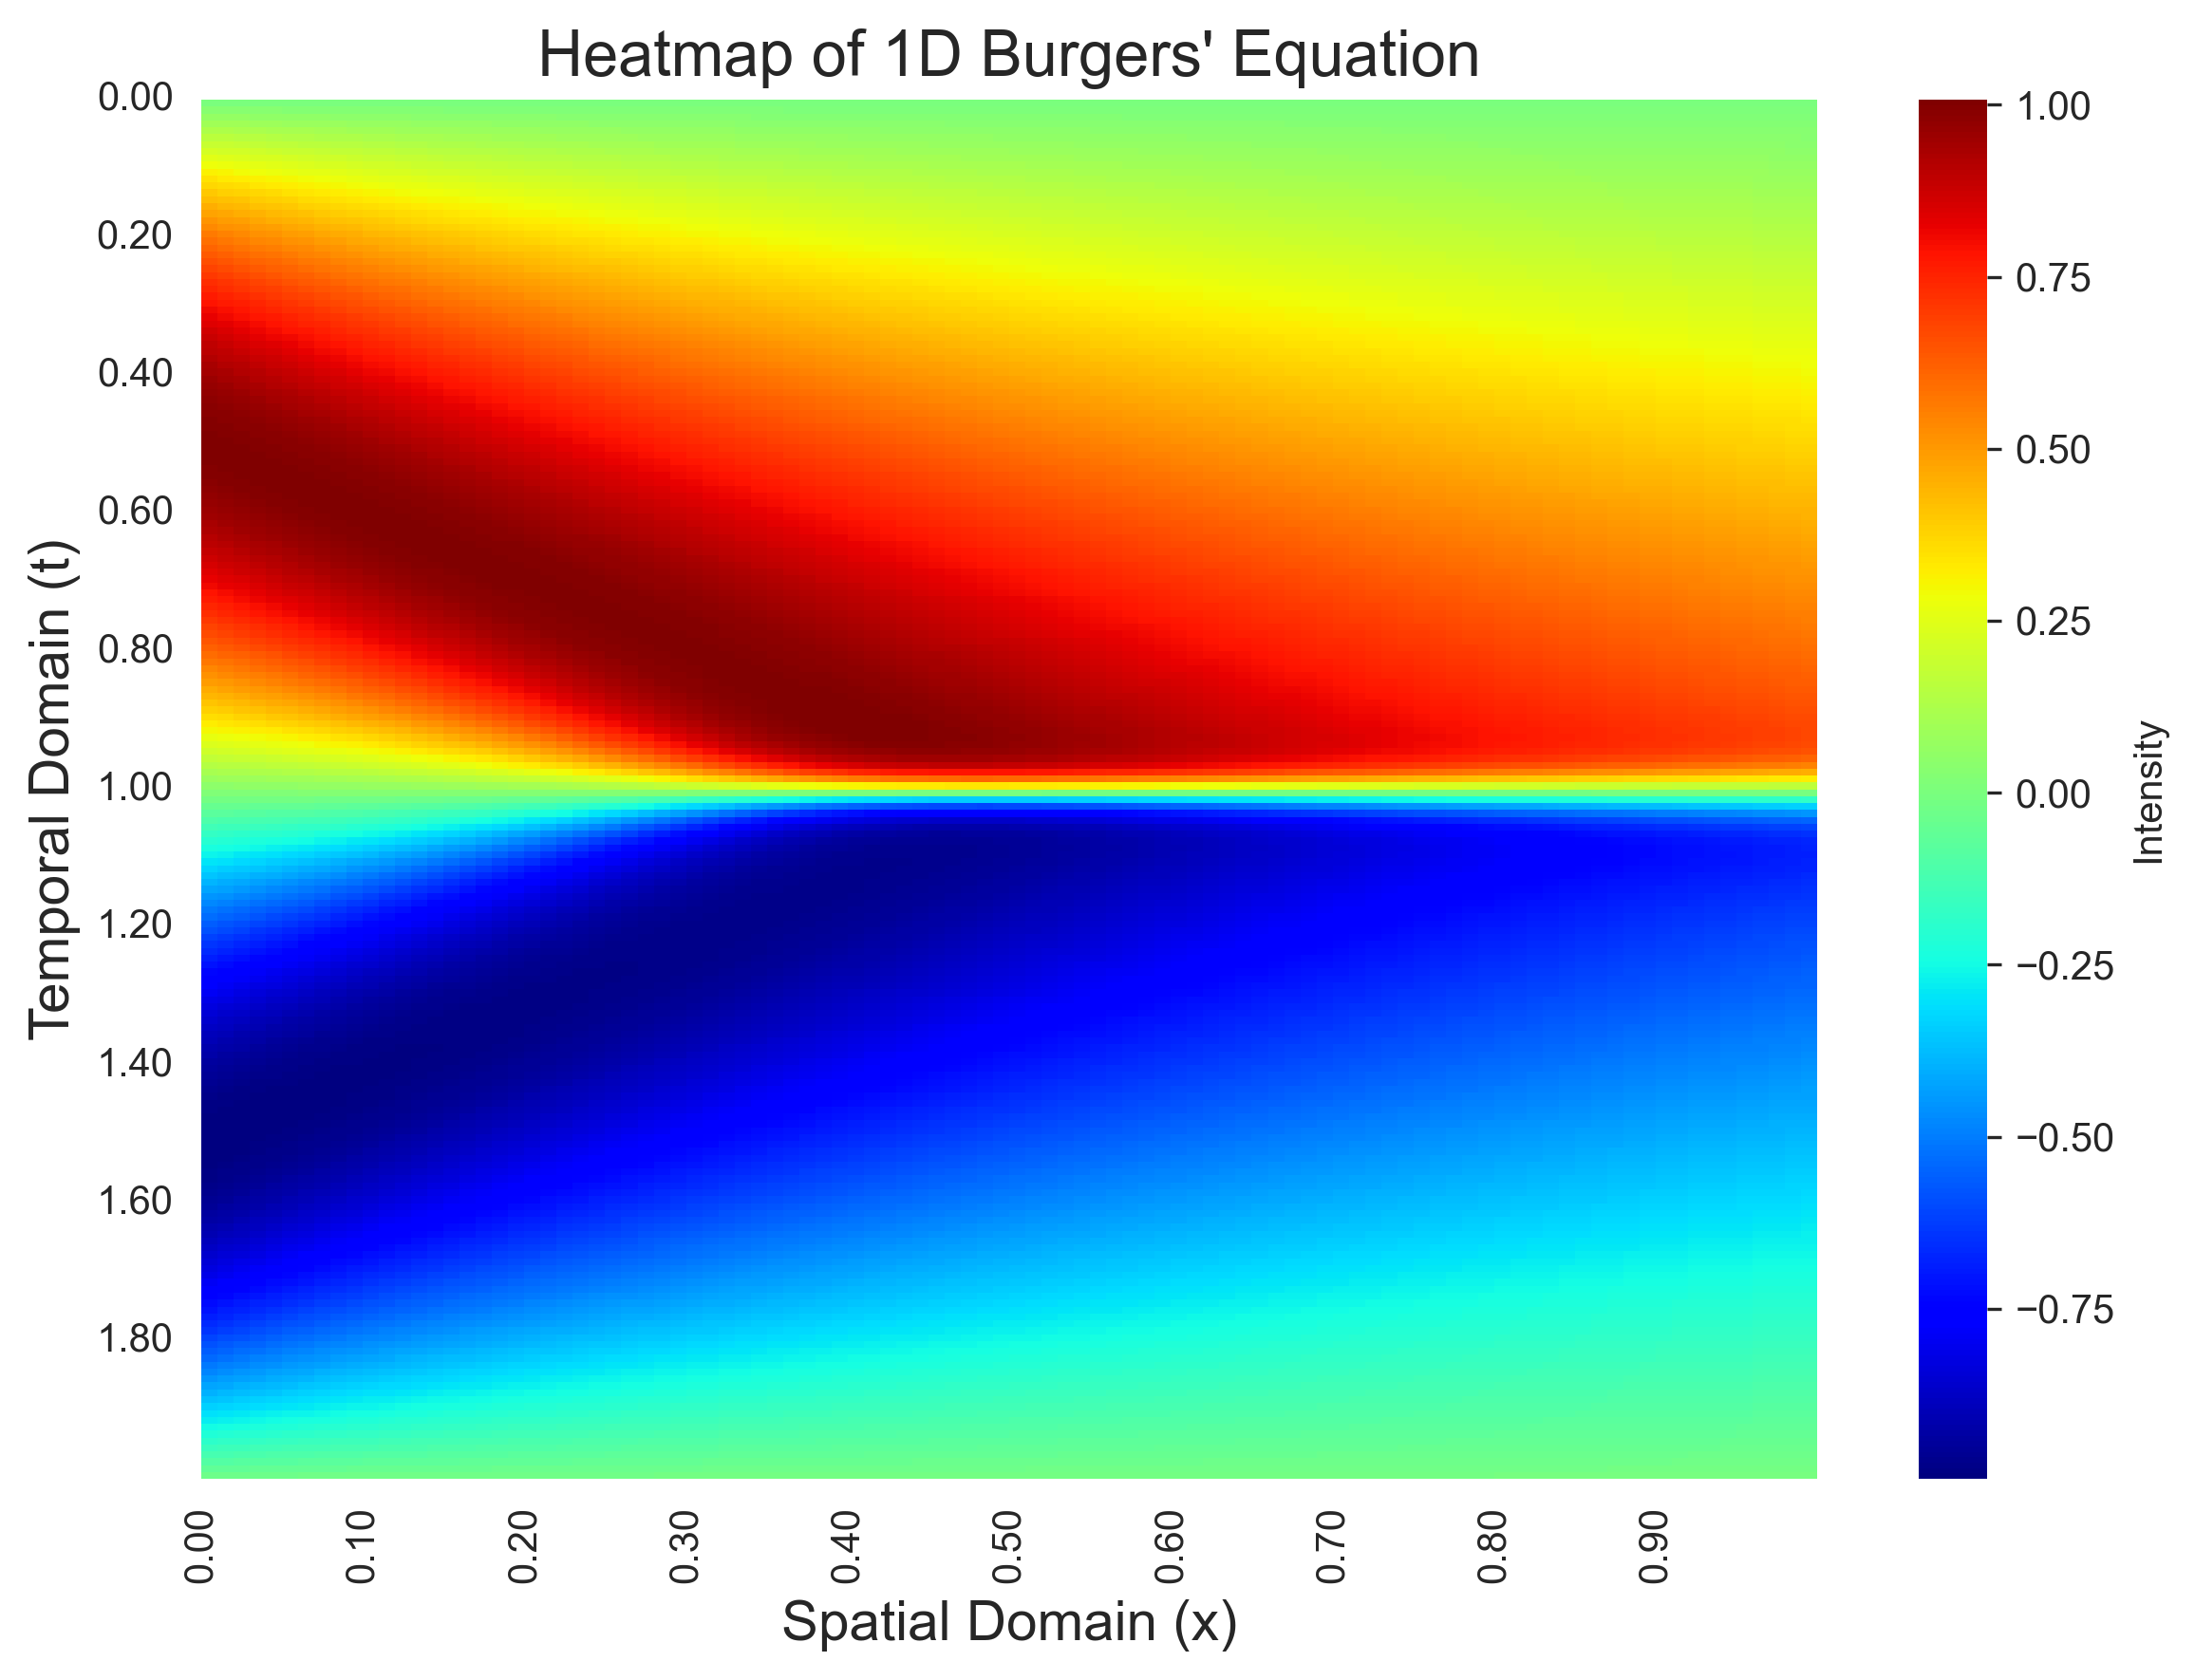

In [30]:
# Training and evaluation
net = Net()
net.train()
predictions = evaluate_model(net.model, net.device)

# Plotting
plot_heatmap(predictions)